# Accurate methods for anchor points identification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination

from cln.AP_identification import AnchorPointsIdentification
from third_party import arc

In [2]:
## Sampling parameters
n_train = 1000
n_cal = 1000
K = 4
num_var = 20
n_informative = 2
n_redundant = num_var - n_informative
n_clusters_per_class = 1
#n_informative = np.maximum(1, int(num_var*0.5))
#n_redundant = 2
#n_clusters_per_class = 2
class_sep = 0.5
random_state = 2026
epsilon0 = 0.01
epsilon = 0.2

In [3]:
T = contamination.construct_T_matrix_simple(K, epsilon)

In [4]:
X, Y = make_classification(n_samples=n_train+n_cal,
                           n_classes=K,
                           n_features=num_var,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           flip_y = epsilon0,
                           class_sep=class_sep, random_state=random_state)
Y = Y.astype(np.int32)
contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+2)
Yt = contamination_process.sample_labels(Y)

# split tmp into train vs calibration
X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, stratify=Y, random_state=random_state + 1)

In [5]:
# Anchor points identified with the benchmark method
black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
black_box_pt = copy.deepcopy(black_box)
black_box_pt.fit(X_train, Yt_train)

p_hat = black_box_pt.predict_proba(X_cal)

gamma_opt = 0.03

# Benchmark: anchor points identified as obs with top gamma % predicted probabilities by a random forest classifier
m_filtered = AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=gamma_opt, ap_filter=False)
Y_anchor_benchmark, _, _ = m_filtered.get_anchor_points()

# Filter anchor points with the elliptic_envelope outlier detection method
m_filtered = AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=gamma_opt, ap_filter=True)
Y_anchor_filtered, _, _ = m_filtered.get_anchor_points()

# Filter anchor points with isolation forests
m_filtered_IF = AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=gamma_opt, ap_filter=True, filter_method="isolation_forest")
Y_anchor_filtered_IF, _, _ = m_filtered_IF.get_anchor_points()

accuracy_benchmark = np.sum(Y_anchor_benchmark==Y_cal)/np.sum(Y_anchor_benchmark != -1)
accuracy_filtered = np.sum(Y_anchor_filtered==Y_cal)/np.sum(Y_anchor_filtered != -1)
accuracy_filtered_IF = np.sum(Y_anchor_filtered_IF==Y_cal)/np.sum(Y_anchor_filtered_IF != -1)

/Users/teresabortolotti/Library/Python/3.9/lib/python/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/teresabortolotti/Library/Python/3.9/lib/python/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/teresabortolotti/Library/Python/3.9/lib/python/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/teresabortolotti/Library/Python/3.9/lib/python/site-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


PLOT RESULTS

In [6]:
# PCA on the full calibration set
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_cal)
Z_anchor_benchmark = Z[Y_anchor_benchmark != -1]
Z_anchor_filtered = Z[Y_anchor_filtered != -1]
Z_anchor_filtered_IF = Z[Y_anchor_filtered_IF != -1]

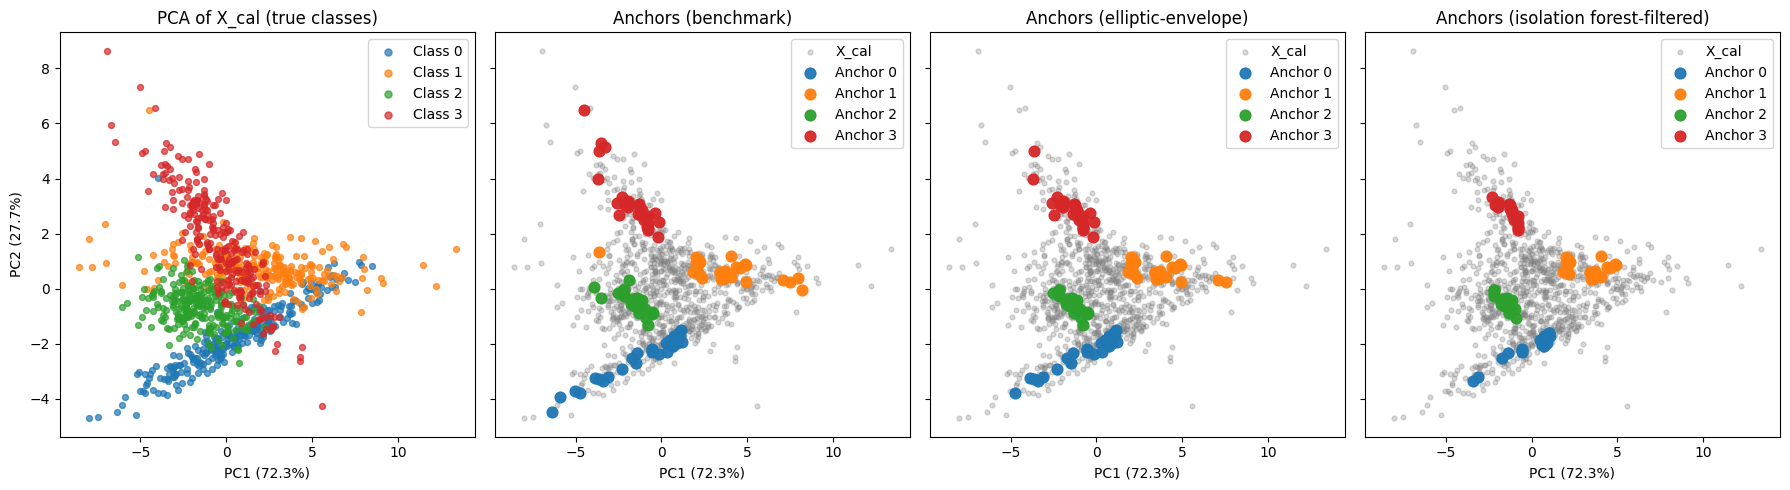

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)

classes = np.unique(Y_cal)


ax = axes[0]
for c in classes:
    mask_c = (Y_cal == c)
    ax.scatter(Z[mask_c, 0], Z[mask_c, 1],
               s=18, alpha=0.7, label=f"Class {c}")

ax.set_title("PCA of X_cal (true classes)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(markerscale=1.2)


ax = axes[1]
ax.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

for c in classes:
    mask_c = (Y_anchor_benchmark == c)
    ax.scatter(Z[mask_c, 0], Z[mask_c, 1],
               s=60, alpha=0.95, label=f"Anchor {c}")

ax.set_title("Anchors (benchmark)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.legend()


ax = axes[2]
ax.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

for c in classes:
    mask_c = (Y_anchor_filtered == c)
    ax.scatter(Z[mask_c, 0], Z[mask_c, 1],
               s=60, alpha=0.95, label=f"Anchor {c}")

ax.set_title("Anchors (elliptic-envelope)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.legend()

ax = axes[3]
ax.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

for c in classes:
    mask_c = (Y_anchor_filtered_IF == c)
    ax.scatter(Z[mask_c, 0], Z[mask_c, 1],
               s=60, alpha=0.95, label=f"Anchor {c}")

ax.set_title("Anchors (isolation forest-filtered)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.legend()


plt.tight_layout()
plt.show()


In [8]:
# Print performances
print("Performance of the Benchmark method")
sys.stdout.flush()
print("\nNumerosity of the anchor points set: {:d}".format(np.sum(Y_anchor_benchmark != -1)))
sys.stdout.flush()
print("\nAccuracy of the anchor points set: {:f}".format(accuracy_benchmark))
sys.stdout.flush()

print("\nPerformance after filtering with elliptic envelope")
sys.stdout.flush()
print("\nNumerosity of the anchor points set: {:d}".format(np.sum(Y_anchor_filtered != -1)))
sys.stdout.flush()
print("\nAccuracy of the anchor points set: {:f}".format(accuracy_filtered))
sys.stdout.flush()

print("\nPerformance after filtering with isolation forest")
sys.stdout.flush()
print("\nNumerosity of the anchor points set: {:d}".format(np.sum(Y_anchor_filtered_IF != -1)))
sys.stdout.flush()
print("\nAccuracy of the anchor points set: {:f}".format(accuracy_filtered_IF))
sys.stdout.flush()

Performance of the Benchmark method

Numerosity of the anchor points set: 120

Accuracy of the anchor points set: 0.925000

Performance after filtering with elliptic envelope

Numerosity of the anchor points set: 108

Accuracy of the anchor points set: 0.925926

Performance after filtering with isolation forest

Numerosity of the anchor points set: 80

Accuracy of the anchor points set: 0.975000


## Results from repeated experiments

In [10]:
from PIL import Image

(-0.5, 2699.5, 2249.5, -0.5)

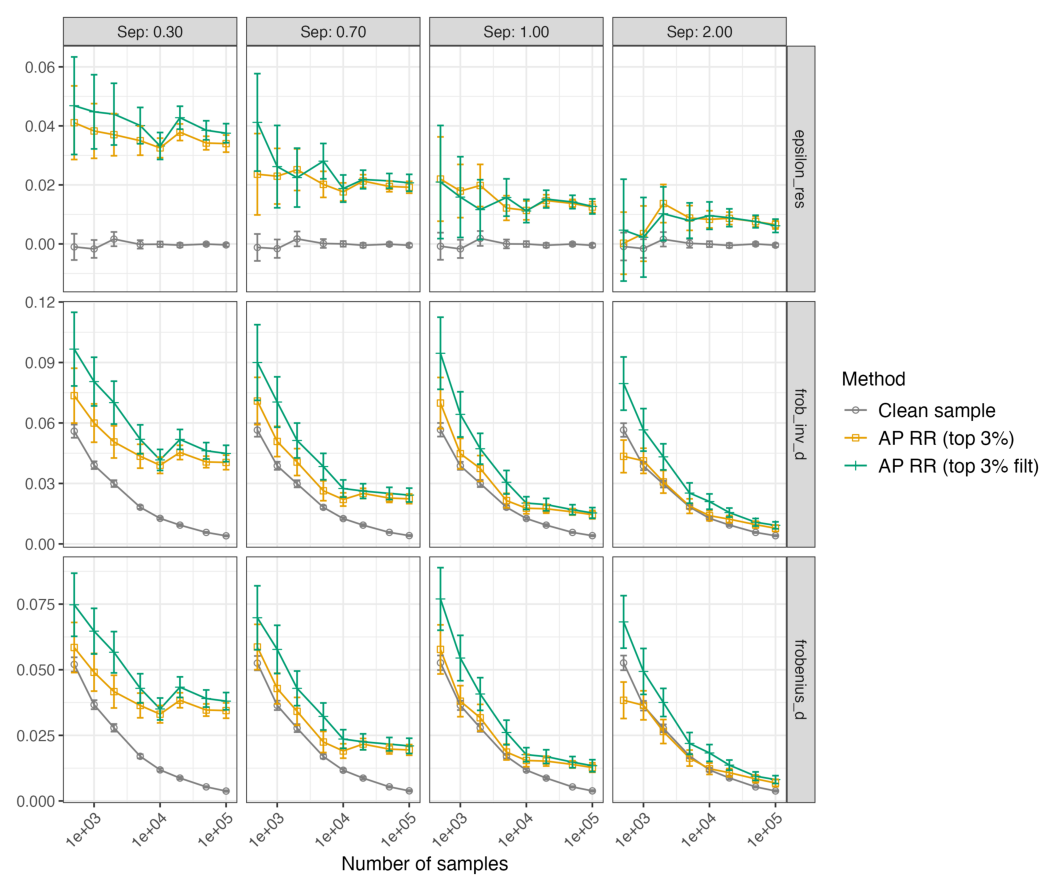

In [11]:
img = Image.open("/Users/teresabortolotti/Documents/VSCode/marginal-noise-adaptive-conformal/experiments/figures/exp803_synthetic1_easy_ntrain10000_K4_nu0_uniform.png")

scale = 0.5
w, h = img.size

plt.figure(figsize=(scale * w / 100, scale * h / 100), dpi=100)
plt.imshow(img)
plt.axis("off")
